# Homework 1 (Due Feb. 10, 2023 at Noon) 

Submit your solution notebook in your directory via github PR.

## Problem 1 (50 pts)

###  Fitting a Line using a Maximum Likelihood Estimator

Last week, you implcitly fitted straight lines with methods of moments estimators (i.e. sample mean and variance) and L-estimators (median and IQR). Generally though, we want some kind of uncertainty estimate for our models, and therefore M-estimators and maximum likelihood estimators in particular are useful.

Assume the scatter in our measurements (the residuals) is generated by a gaussian process i.e.:

>$ y_i = a x_i + b + r_i $

where $r_i$ is drawn from $N(0, \sigma)$. Here, $\sigma$ is the error the measurement induces.

To use an M-estimator/MLE, you have to specify the likelihood function. First, the probability $p(y_i|x_i, M(a, b), \sigma)$ that a particular point $y_i$ would be measured is just the normal distribution:

>$ p(y_i|x_i, M(a, b), \sigma) = N(y_i - M(x)|\sigma) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp \left( - \frac{(y_i - M(x_i))^2}{2 \sigma^2} \right) $.

Given what we discussed in class, we can write down the $\ln L$

>$ \ln L(a, b) = constant - \frac{1}{2 \sigma^2} \sum_{i=1}^N (y_i - M(x_i))^2 $

This is the expression that we now minimize with respect to $a$ and $b$ to find ML estimators for those parameters. 


And as we discussed in class, this is equivalent to minimizing the sum of the squares or a _least-squares method_.

## MLE with outliers

Let's apply the MLE to data with uncertainties where these uncertainties include outliers. 
I've defined a dataset below:

Your mission is to:

- write a function that computes the squared loss, and incorporates the uncertainties on the measurements, $dy$ (10 pts)
- Fit a line to the full sample by evaluating this likelihood on a grid of a, b (10 pts)
- Use sigma-clipping or an L-estimator for outlier rejection and fit a line to the data with outliers rejected (10 pts) and make a QQ plot of the residuals (10 pts)
- Define a new likelihood function that implements the Huber loss, also incorporating the measurement uncertainties $dy$ (10 pts)
- Fit a new line to all of the data (no outlier rejection) with the new Huber likelihod, except now use scipy.optimize.fmin instead of a grid search, and you know the drill by now - QQ plot of the residuals (10 pts)

Recommended reading: David Hogg, Jo Bovy, and Dustin Lang: "Data analysis recipes: Fitting a model to data", 2010: https://arxiv.org/abs/1008.4686

In [1]:
%matplotlib inline

Minimum x2 of 290.05548910112805 at a = 1.1 and b = 209


Text(0.5, 1.0, 'Unclipped Squared Loss')

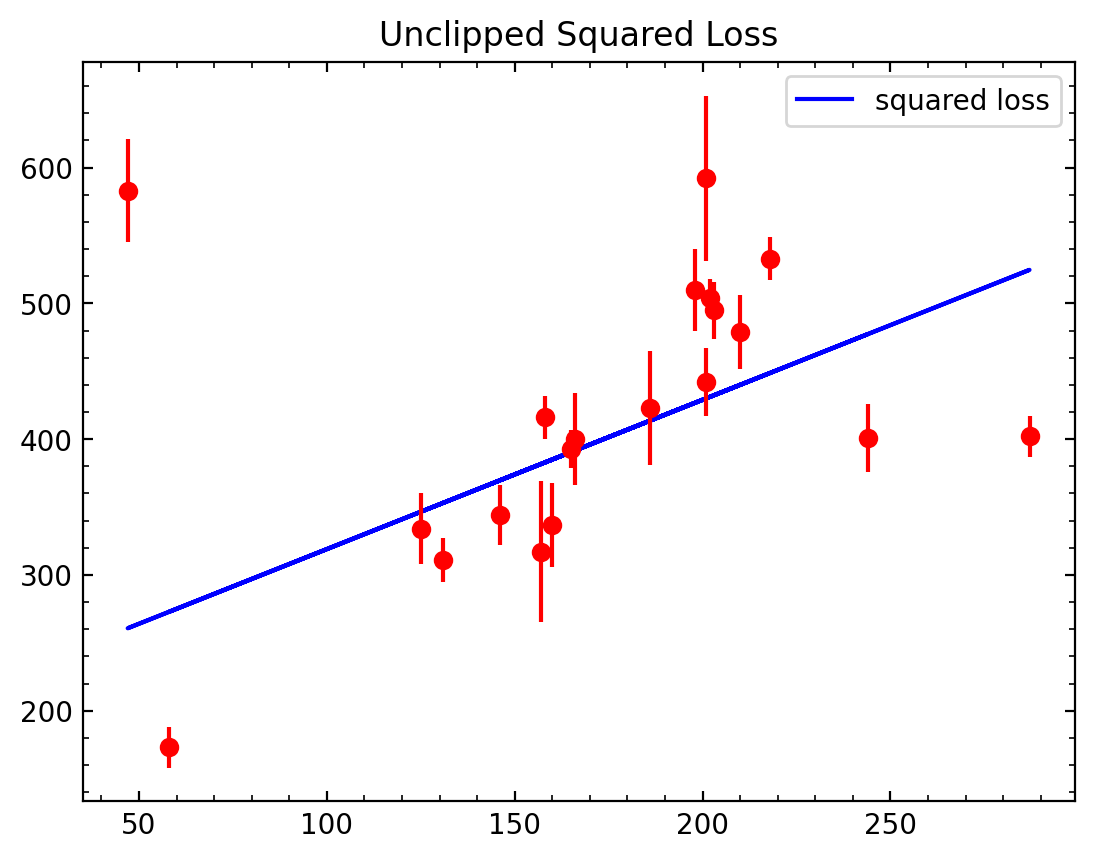

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import scipy.optimize
from statsmodels.api import qqplot
import astropy.stats as asts
from astroML.datasets import fetch_hogg2010test

def plotutils(ax): # Standard plotting utility
   ax.xaxis.set_minor_locator(AutoMinorLocator())
   ax.yaxis.set_minor_locator(AutoMinorLocator())
   ax.tick_params(which='both', direction='in', right=True, top=True)

# this just makes plots a bit easier on my laptop - disable as needed
%config InlineBackend.figure_format='retina'

#------------------------------------------------------------
# Get data: this includes outliers
data = fetch_hogg2010test()
x = data['x']
y = data['y']
dy = data['sigma_y']

def locate_min(x): # Find the indices of the min of a 2D array
    k = x.argmin()
    ncol = x.shape[1]
    return int(k/ncol), k%ncol

def sqlo(xi, yi, dyi, a, b): # A function to return the weighted squared loss of a single point, given a & b
    yp = (a*xi) + b
    u = yp - yi
    return (u**2.)/(dyi**2.)

def sqx(xarr, yarr, dyarr, a, b): # A function to return the x^2 of a distribution using squared loss,
                                     # given a & b
    sq = 0
    for i in range(len(xarr)):
        sq += sqlo(xarr[i], yarr[i], dyarr[i], a, b)
    return sq

amin, amax, astep = 1, 10, 0.05
bmin, bmax, bstep = 10, 500, 1
aarr = np.arange(amin, amax, astep)
barr = np.arange(bmin, bmax, bstep)
sqxs = np.zeros((len(aarr), len(barr)))

for n in range(len(aarr)):
    for m in range(len(barr)):
        sqxs[n][m] = sqx(x, y, dy, aarr[n], barr[m])

sqma, sqmb = locate_min(sqxs)
print('Minimum x2 of ' + str(sqxs.min()) + ' at a = ' + str(aarr[sqma]) + ' and b = ' + str(barr[sqmb]))

ypr = (aarr[sqma] * x) + barr[sqmb]

# Plotting first figure
fig = plt.figure()
ax1 = fig.add_subplot()
plotutils(ax1)
ax1.plot(x, ypr, label='squared loss', color='b')
ax1.errorbar(x, y, yerr=dy, fmt='or')
#axA.set_xlim(left=dataZ["Wavelength"].min(), right=dataZ["Wavelength"].max())
ax1.legend()
#plt.imshow(sqxs[0:30], cmap='hot', interpolation='nearest')
ax1.set_title('Unclipped Squared Loss')

Minimum x2 of 48.268603565179625 at a = 1.4500000000000004 and b = 152


Text(0.5, 1.0, 'Clipped Square Loss')

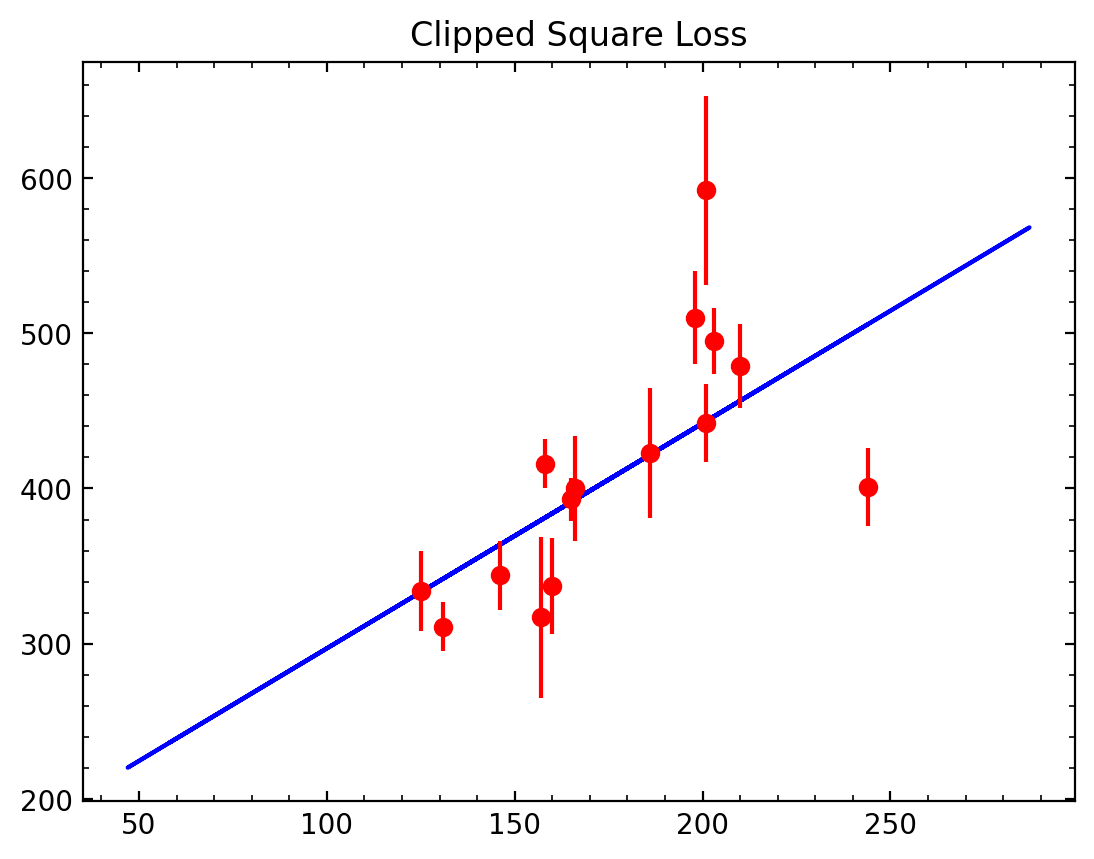

In [3]:
# Clipping at 2 sigma
res = (y - ypr)/dy
clipped = asts.sigma_clip(res, sigma=2)
clipx = np.ma.compressed(np.ma.masked_where(np.ma.getmask(clipped), x))
clipy = np.ma.compressed(np.ma.masked_where(np.ma.getmask(clipped), y))
clipdy = np.ma.compressed(np.ma.masked_where(np.ma.getmask(clipped), dy))

sqxsc = np.zeros((len(aarr), len(barr)))
for n in range(len(aarr)):
    for m in range(len(barr)):
        sqxsc[n][m] = sqx(clipx, clipy, clipdy, aarr[n], barr[m])

sqmac, sqmbc = locate_min(sqxsc)
print('Minimum x2 of ' + str(sqxsc.min()) + ' at a = ' + str(aarr[sqmac]) + ' and b = ' + str(barr[sqmbc]))

yprc = (aarr[sqmac] * x) + barr[sqmbc]

# Plot
fig = plt.figure()
ax2 = fig.add_subplot()
plotutils(ax2)
ax2.plot(x, yprc, label='squared loss', color='b')
ax2.errorbar(clipx, clipy, yerr=clipdy, fmt='or')
ax2.set_title('Clipped Square Loss')

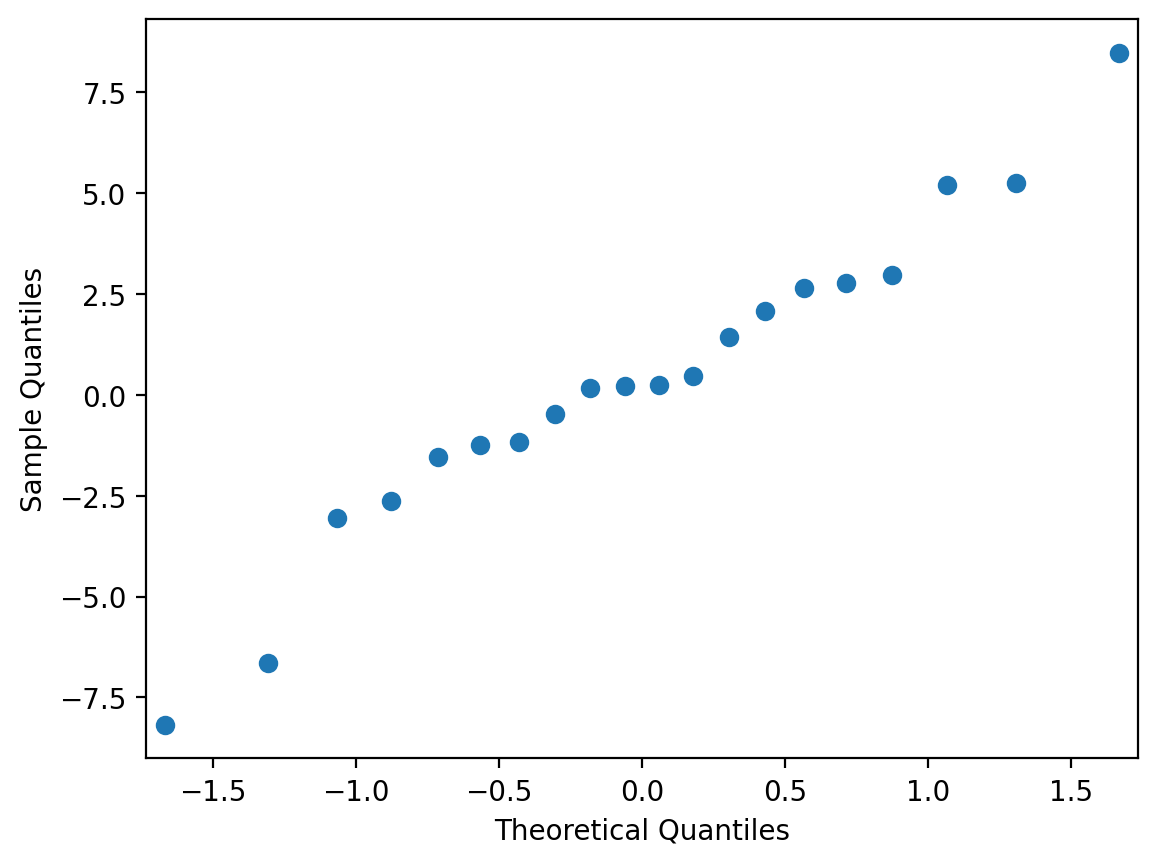

In [4]:
# QQplot
qqplot(res);

Optimization terminated successfully.
         Current function value: 10.319965
         Iterations: 67
         Function evaluations: 133
Minimum x2 of 10.319965408051562 at a = 1.9199978574417136 and b = 10.319965408051562


Text(0.5, 1.0, 'Unclipped Huber Loss')

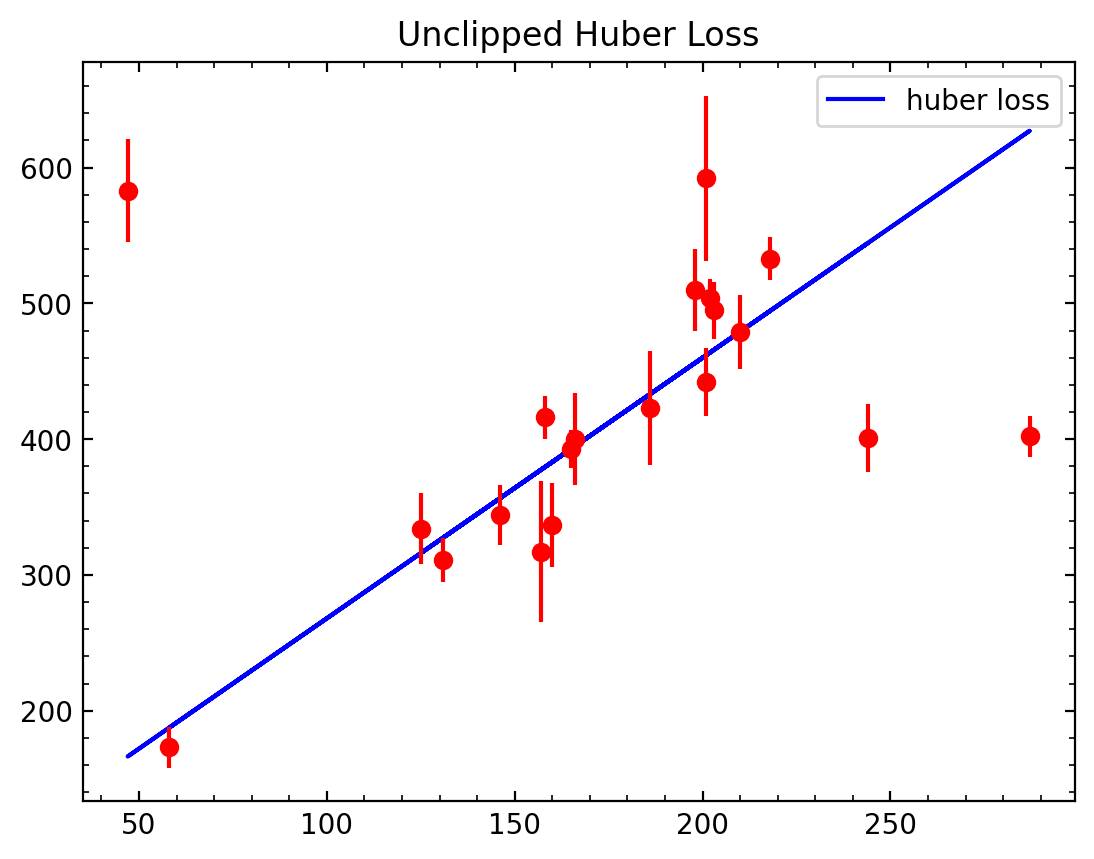

In [5]:
def hulo(xi, yi, dyi, a, b): # A function to return the weighted Huber loss of a single point, given a & b
    d = 0.2 # Just choode a delta?
    yp = (a*xi) + b
    u = yp - yi
    if abs(u) <= d:
        hul = (u**2.)/(2 * (dyi**2.))
    else:
        hul = (d * (abs(u) - (d / 2))) / dyi
    return hul

def hux(xarr, yarr, dyarr, a, b): # A function to return the x^2 of a distribution using Huber loss,
                                  # given a & b
    hu = 0
    for i in range(len(xarr)):
        hu += hulo(xarr[i], yarr[i], dyarr[i], a, b)
    return hu

def badfunction(ab): # A poorly written function that will only work here because it assumes there
                       # is an x, y, and dy
    return hux(x, y, dy, ab[0], ab[1])

# amin, amax, astep = 1, 10, 0.05
# bmin, bmax, bstep = 10, 500, 1
# aarr = np.arange(amin, amax, astep)
# barr = np.arange(bmin, bmax, bstep)
# huxs = np.zeros((len(aarr), len(barr)))

# for n in range(len(aarr)):
#     for m in range(len(barr)):
#         huxs[n][m] = hux(x, y, dy, aarr[n], barr[m])

# huma, humb = locate_min(huxs)

amin, bmin = scipy.optimize.fmin(badfunction, [1.1, 209.])
humin = hux(x, y, dy, amin, bmin)
print('Minimum x2 of ' + str(humin) + ' at a = ' + str(amin) + ' and b = ' + str(humin))

ypr = (amin * x) + bmin

# Plotting Huber figure
fig = plt.figure()
ax3 = fig.add_subplot()
plotutils(ax3)
ax3.plot(x, ypr, label='huber loss', color='b')
ax3.errorbar(x, y, yerr=dy, fmt='or')
ax3.legend()
ax3.set_title('Unclipped Huber Loss')

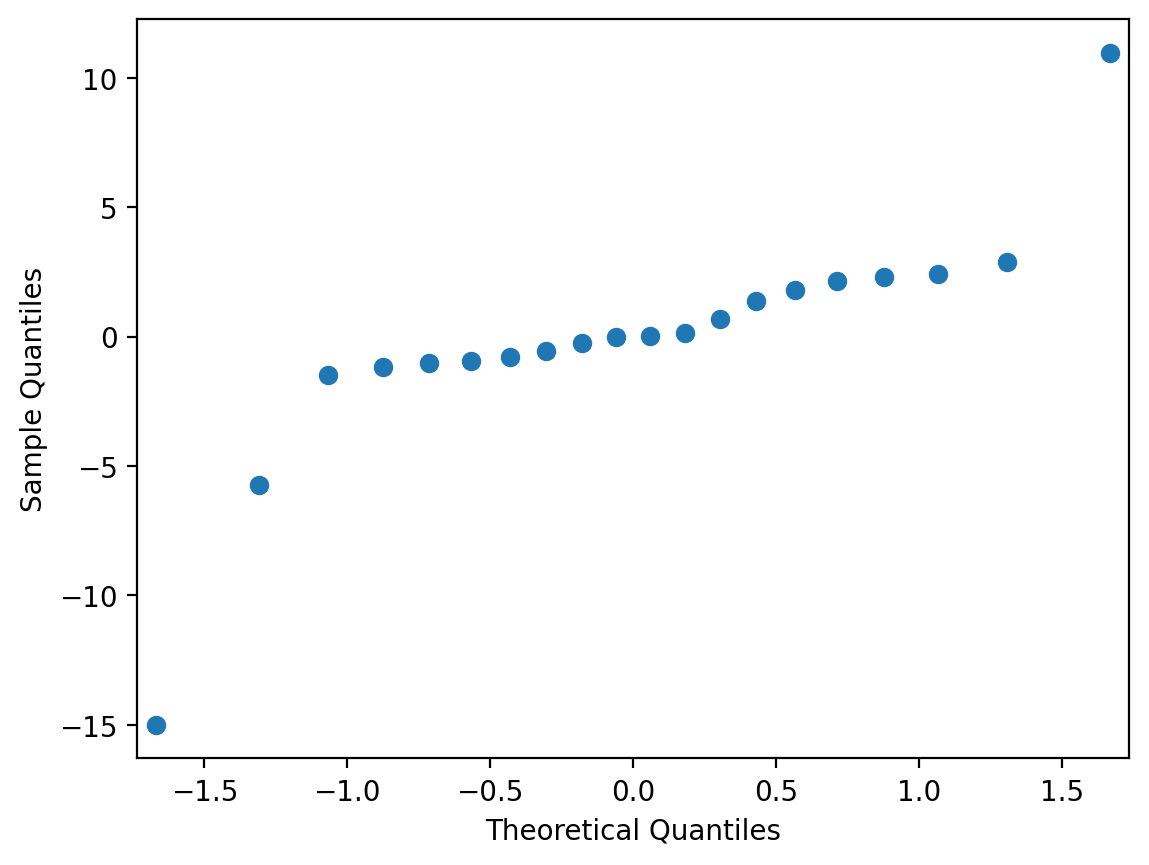

In [6]:
# QQplot Huber
res = (y - ypr)/dy
qqplot(res);

## Problem 2

The demo data set for this part is the Wesenheit index of the OGLE-III fundamental-mode and first overtone classical Cepheids. 

These stars are awesome because you can use them to measure distances. Here's a nice [youtube video](https://www.youtube.com/watch?v=iyisAjHdhas) on these stars.

You'll try to estimate their period-luminosity relationship. 

The Wesenheit index is defined as `W = I - 1.55(V - I)`, and its main advantage over using simply the I or V photometry is that it is insensitive to extinction. It is denoted by 'W' among the data columns. 

Other columns are 'name', the identifier of the star; 'RA0' (in decimal hours) and 'Decl0' (in decimal degrees), celestial coordinates; 'Mode', the mode of the Cepheid ('F' indicates fundamental-mode, '1' indicates first overtone star); 'Cloud', indicating which Magellanic Cloud the star belongs to; 'logP1', the base-10 logarithm of the period in days; 'VI', the colour V-I.


Split the data into LMC and SMC, and then again by mode F and 1, and plot the `W` on the y-axis vs `log(P1)` on x.
Fit or estimate straight lines to each of the four samples using your solution to Problem 1. (10 pts)

Compute the residuals of each sample to it's respective line. Do these residuals look like a normal distribution? If not, speculate on why (WATCH THE YOUTUBE VIDEO!) (10 pts)

Plot the residuals color coded by if they are positive or negative vs RA and Dec (just like a Hess diagram in Problem 1). (15 pts)

Finally, plot the residuals against the fitted `W` values, and just to anticipate the next homework assignment, also plot `log(P1) vs V-I`. Comment on what you are seeing. (15 pts)

Optimization terminated successfully.
         Current function value: 11.312888
         Iterations: 40
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: 8.296653
         Iterations: 39
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: 36.316879
         Iterations: 39
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: 24.766247
         Iterations: 44
         Function evaluations: 84


Text(0.5, 1.0, 'Wesenheit Index of Cepheids')

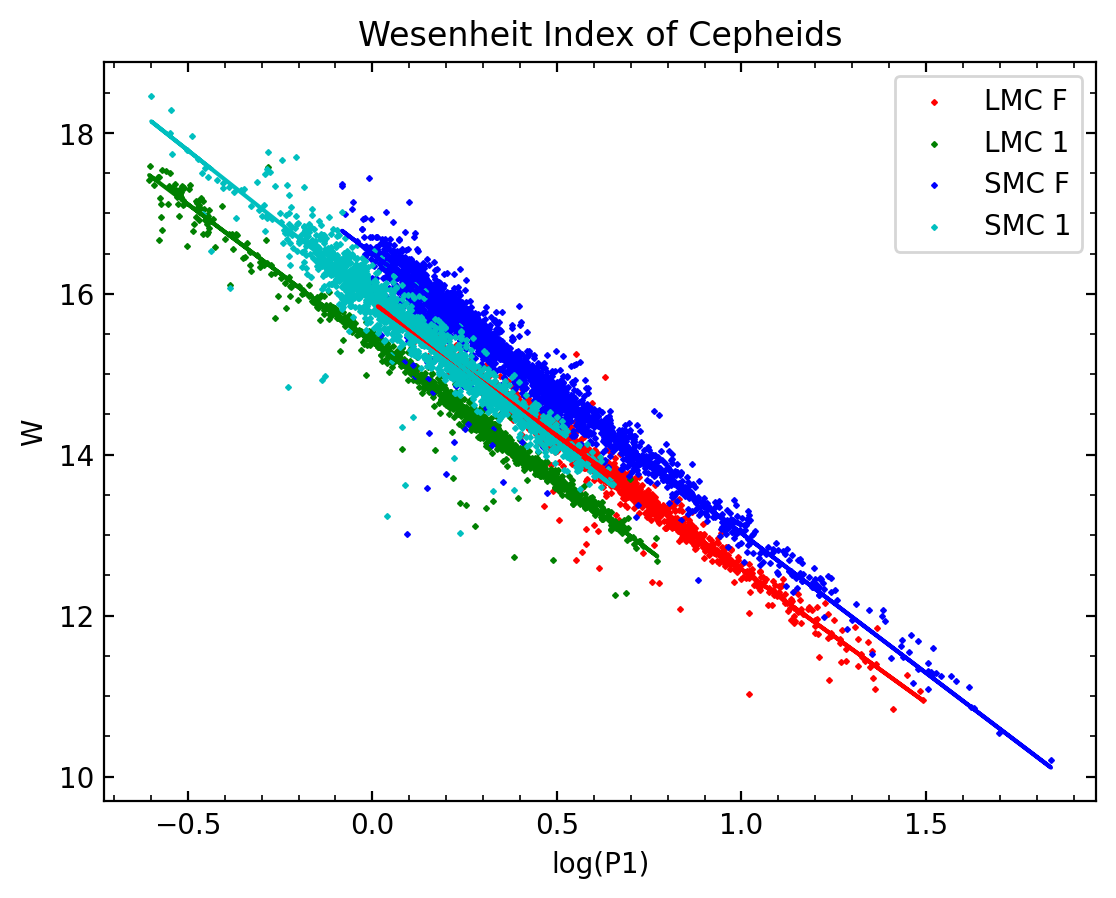

In [7]:
import pandas as pd

def hulo2(xi, yi, a, b): # A function to return the weighted Huber loss of a single point, given a & b, no dy
    d = 0.2 # Just choode a delta?
    yp = (a*xi) + b
    u = yp - yi
    if abs(u) <= d:
        hul = (u**2.)/2
    else:
        hul = (d * (abs(u) - (d / 2)))
    return hul

def hux2(xarr, yarr, a, b): # A function to return the x^2 of a distribution using Huber loss,
                                  # given a & b, no dy
    hu = 0
    for i in range(len(xarr)):
        hu += hulo2(xarr[i], yarr[i], a, b)
    return hu

def sillyguy(ab, xarr, yarr): # A function for scipy optimize to work on
    return hux2(xarr, yarr, ab[0], ab[1])


# Import and split data
df = pd.read_csv('Cepheids.csv')
dfLMC = df.where(df['Cloud'] == 'LMC').dropna()
dfSMC = df.where(df['Cloud'] == 'SMC').dropna()
dfLMCF = df.where(dfLMC['Mode'] == 'F').dropna()
dfLMC1 = df.where(dfLMC['Mode'] == '1').dropna()
dfSMCF = df.where(dfSMC['Mode'] == 'F').dropna()
dfSMC1 = df.where(dfSMC['Mode'] == '1').dropna()
dfs = [dfLMCF, dfLMC1, dfSMCF, dfSMC1]
names = ['LMC F', 'LMC 1', 'SMC F', 'SMC 1']
colors = ['r', 'g', 'b', 'c']

#amin, bmin = scipy.optimize.fmin(badfunction2, [-2, 16])
#humin = hux2(x, y, dy, amin, bmin)
#print('Minimum x2 of ' + str(humin) + ' at a = ' + str(amin) + ' and b = ' + str(humin))

#ypr = (aarr[huma] * x) + barr[humb]

# Plotting W v logP1
fig = plt.figure()
ax4 = fig.add_subplot()
plotutils(ax4)
for n in range(len(dfs)):
    x = np.array(dfs[n]['logP1'])
    y = np.array(dfs[n]['W'])
    ax4.scatter(x, y, label=names[n], color=colors[n], marker='x', s=2)
    amin, bmin = scipy.optimize.fmin(sillyguy, [-2, 16], args=(x, y))
    ypr = (amin * x) + bmin
    ax4.plot(x, ypr, color=colors[n])
ax4.legend()
ax4.set_xlabel('log(P1)')
ax4.set_ylabel('W')
ax4.set_title('Wesenheit Index of Cepheids')

Optimization terminated successfully.
         Current function value: 11.312888
         Iterations: 40
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: 8.296653
         Iterations: 39
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: 36.316879
         Iterations: 39
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: 24.766247
         Iterations: 44
         Function evaluations: 84


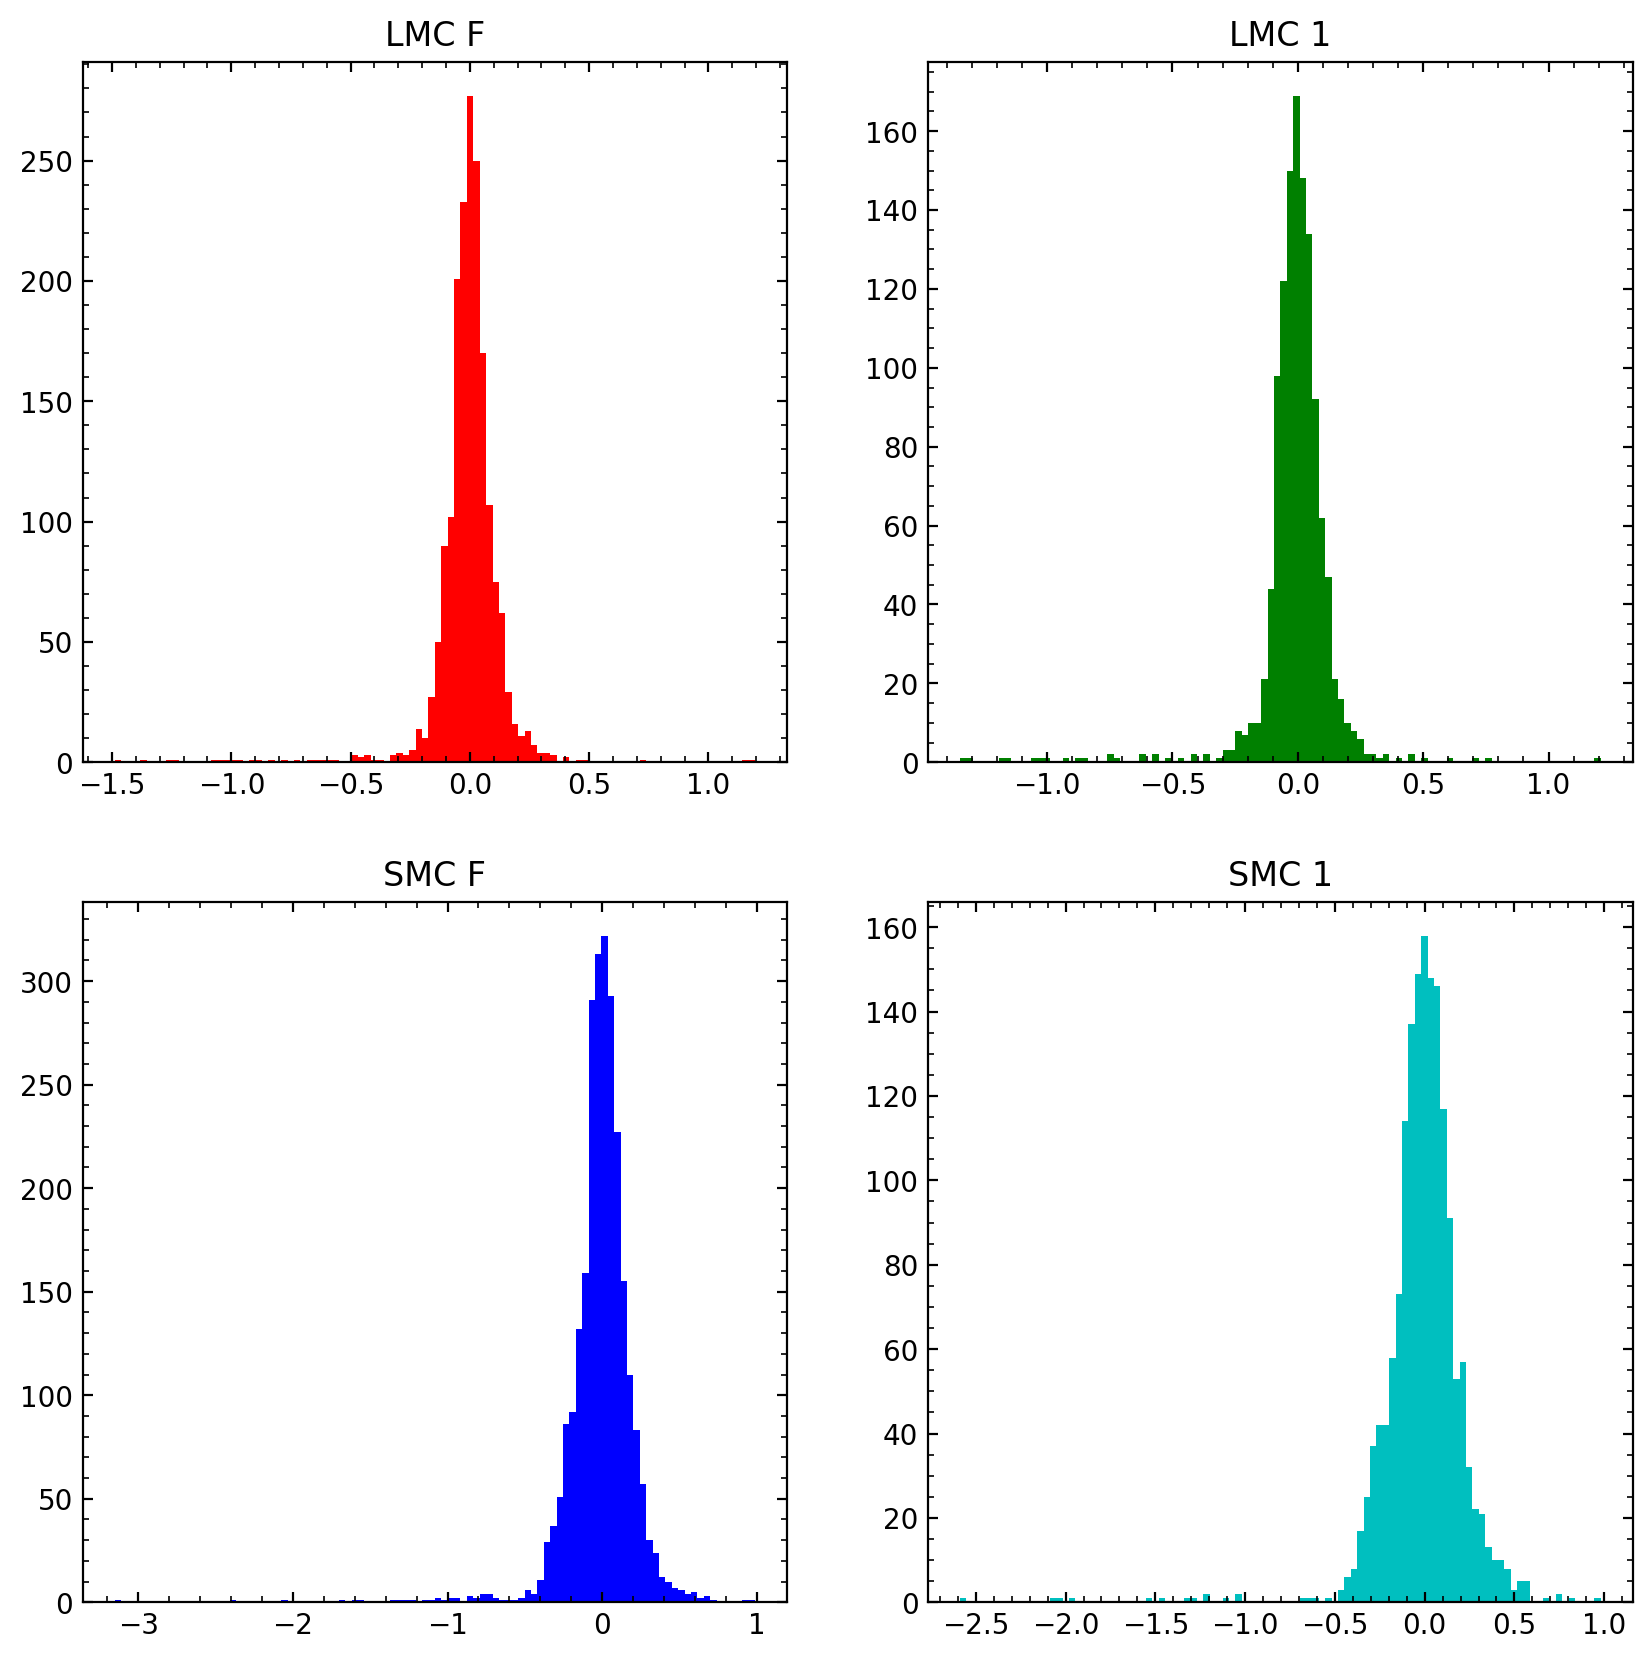

In [8]:
# Residuals gaussian?
fig = plt.figure(figsize=(10, 10))
for n in range(len(dfs)):
    x = np.array(dfs[n]['logP1'])
    y = np.array(dfs[n]['W'])
    amin, bmin = scipy.optimize.fmin(sillyguy, [-2, 16], args=(x, y))
    ypr = (amin * x) + bmin
    res = y - ypr
    ax5 = fig.add_subplot(2, 2, n+1)
    plotutils(ax5)
    ax5.hist(res, 100, color=colors[n])
    ax5.set_title(names[n])

Well, if this is a normal distribution, it's tighter than clothes after a growth spurt.  This seems to be too sharp and tight a relationship to be Gaussian, which I would take to be because either a) the real period-luminosity relationship is extremely strong, which makes these so useful in distance calculations, and/or b) we have taken extremely precise data on these objects because of that same reason, so we have a really strong confidence in measurements.

Optimization terminated successfully.
         Current function value: 11.312888
         Iterations: 40
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: 8.296653
         Iterations: 39
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: 36.316879
         Iterations: 39
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: 24.766247
         Iterations: 44
         Function evaluations: 84


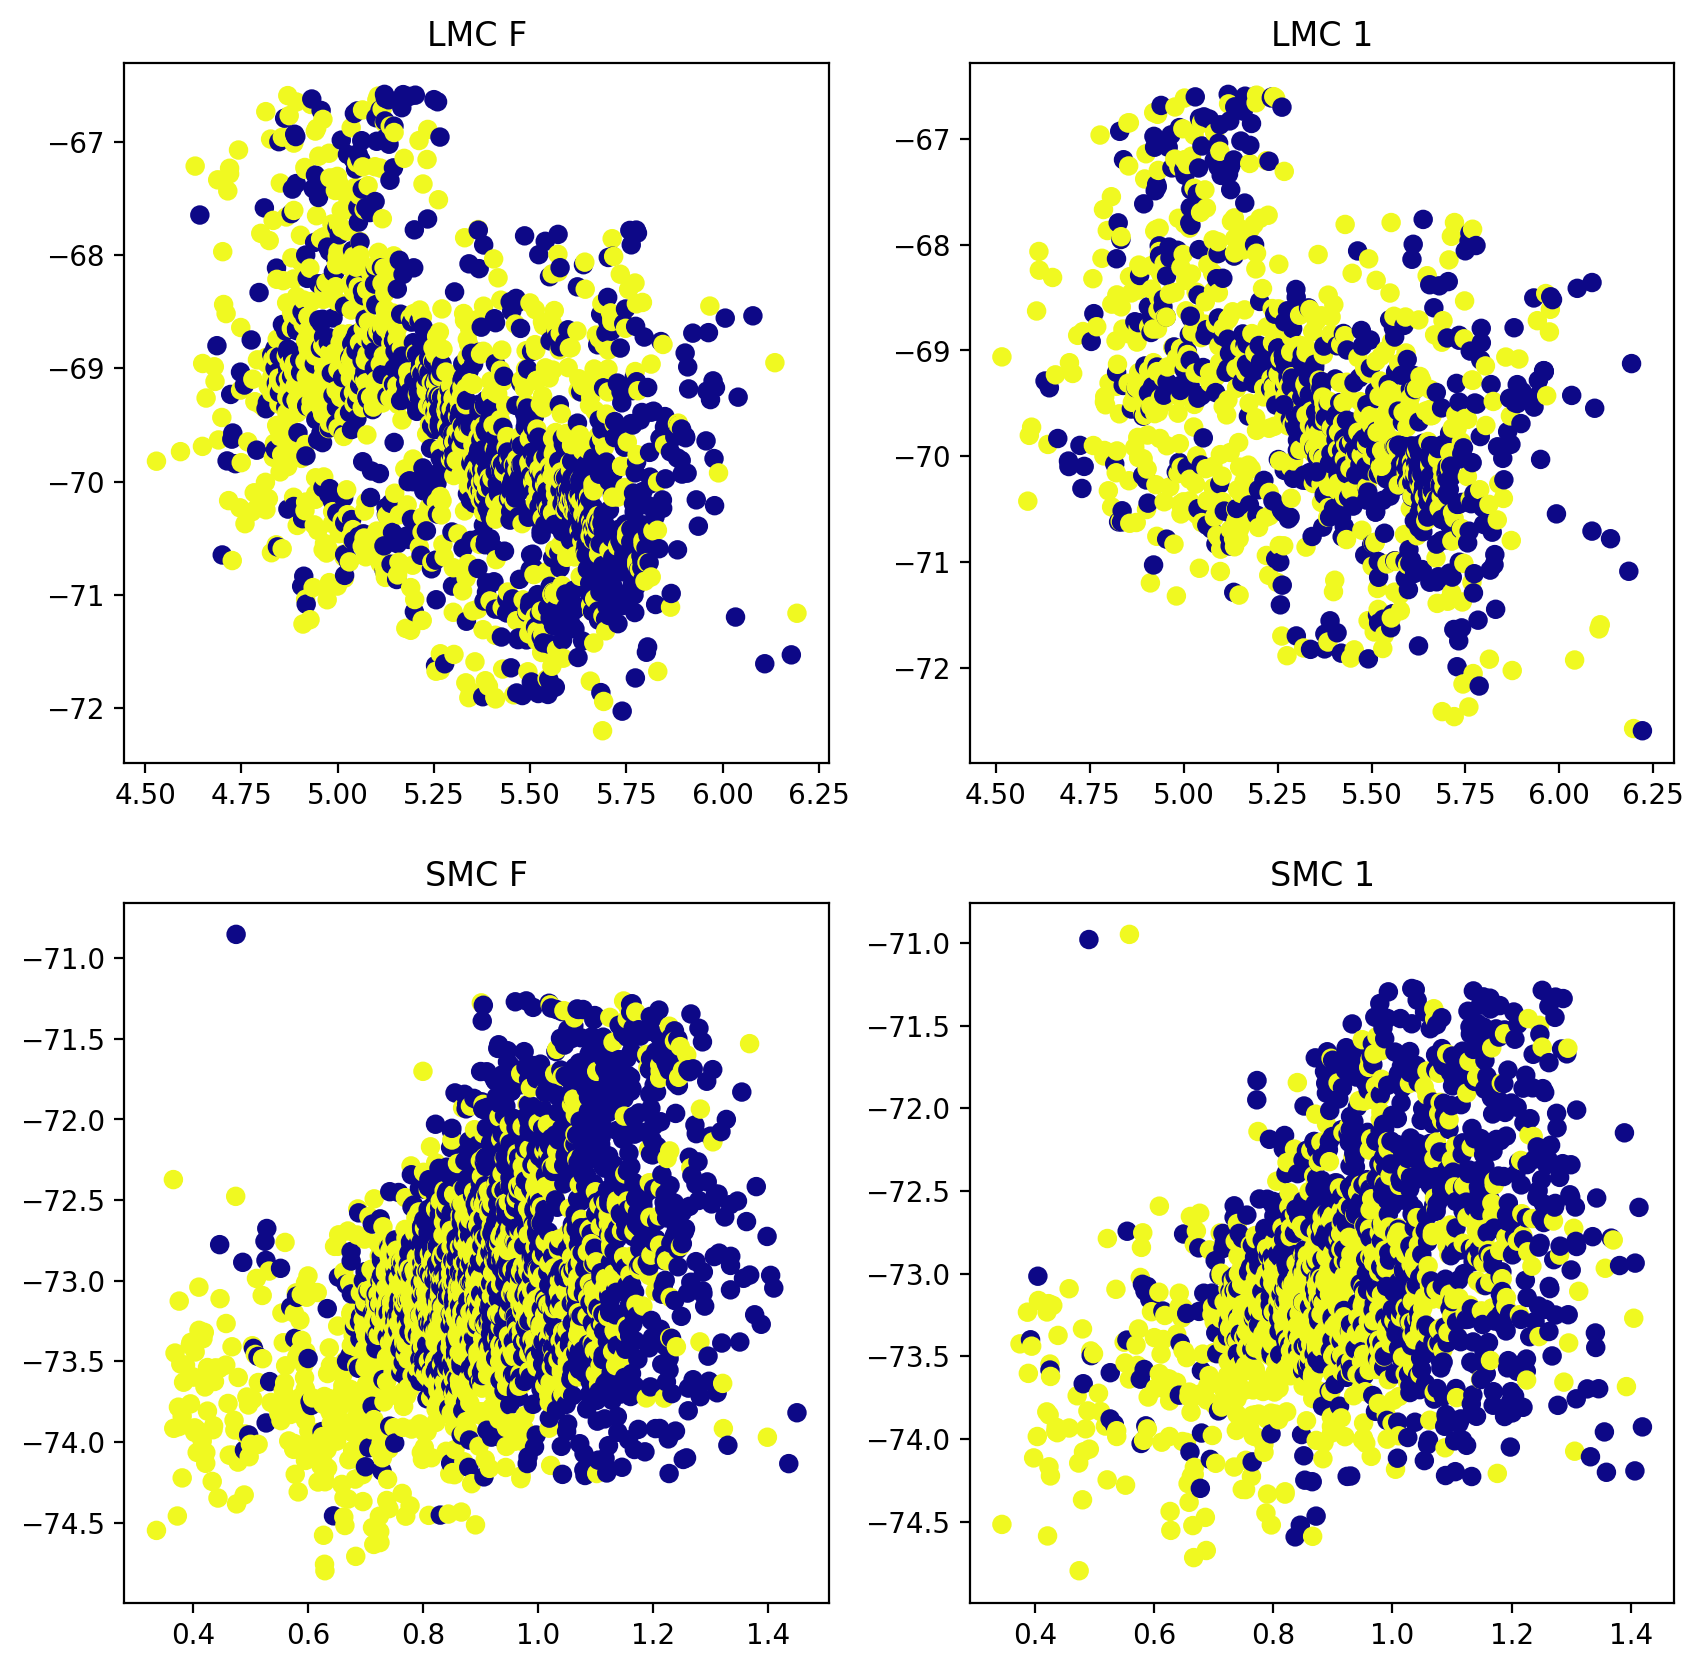

In [9]:
# Residuals colormap
fig = plt.figure(figsize=(10, 10))
for n in range(len(dfs)):
    x = np.array(dfs[n]['logP1'])
    y = np.array(dfs[n]['W'])
    amin, bmin = scipy.optimize.fmin(sillyguy, [-2, 16], args=(x, y))
    ypr = (amin * x) + bmin
    res = y - ypr
    res = res > 0
    res = res.astype(int)
    ax6 = fig.add_subplot(2, 2, n+1)
    ax6.scatter(dfs[n]['RA0'], dfs[n]['Decl0'], c=res, cmap='plasma')
    ax6.set_title(names[n])

Optimization terminated successfully.
         Current function value: 11.312888
         Iterations: 40
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: 8.296653
         Iterations: 39
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: 36.316879
         Iterations: 39
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: 24.766247
         Iterations: 44
         Function evaluations: 84


Text(0.5, 1.0, 'Residuals v. W')

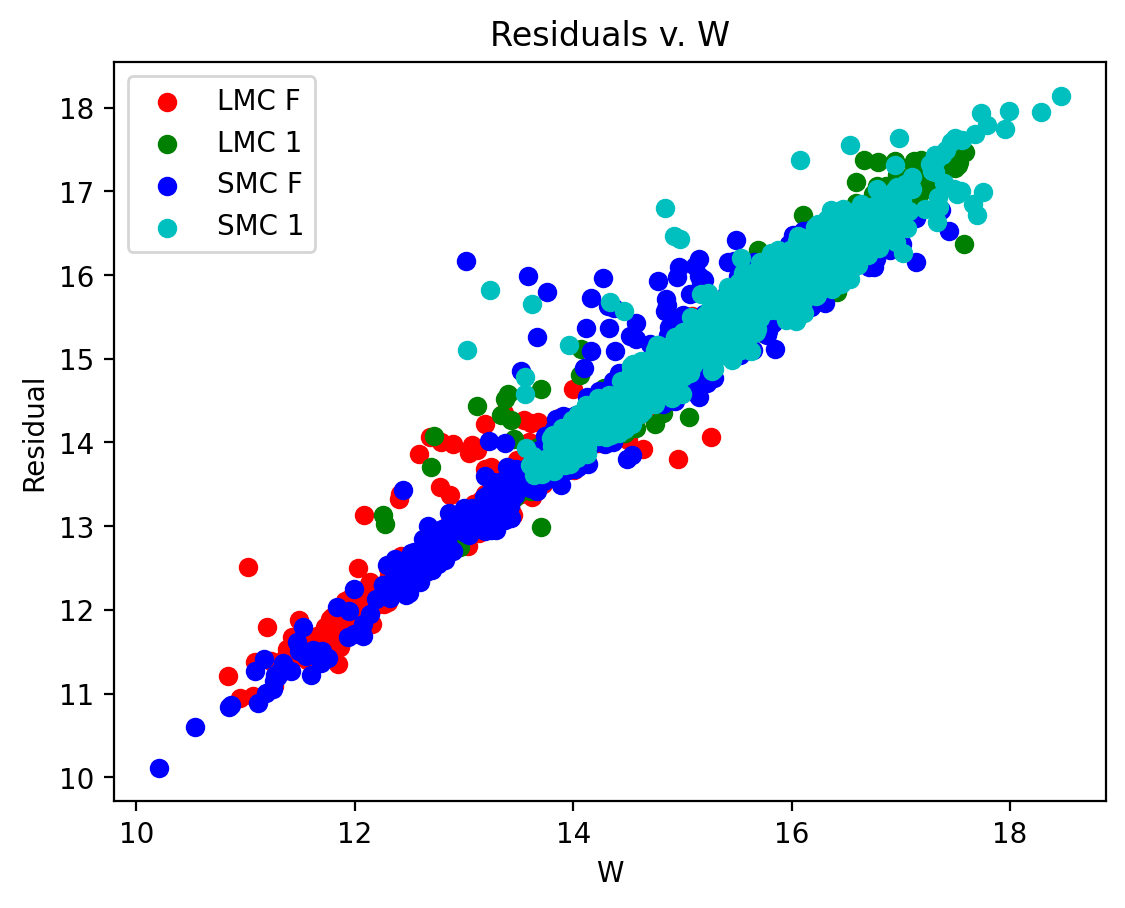

In [10]:
# Last plots
fig = plt.figure()
ax7 = fig.add_subplot()
for n in range(len(dfs)):
    x = np.array(dfs[n]['logP1'])
    y = np.array(dfs[n]['W'])
    amin, bmin = scipy.optimize.fmin(sillyguy, [-2, 16], args=(x, y))
    ypr = (amin * x) + bmin
    res = y - ypr
    ax7.scatter(y, ypr, label=names[n], color=colors[n])
ax7.legend()
ax7.set_xlabel('W')
ax7.set_ylabel('Residual')
ax7.set_title('Residuals v. W')

Text(0.5, 1.0, 'Log(P1) vs V-I')

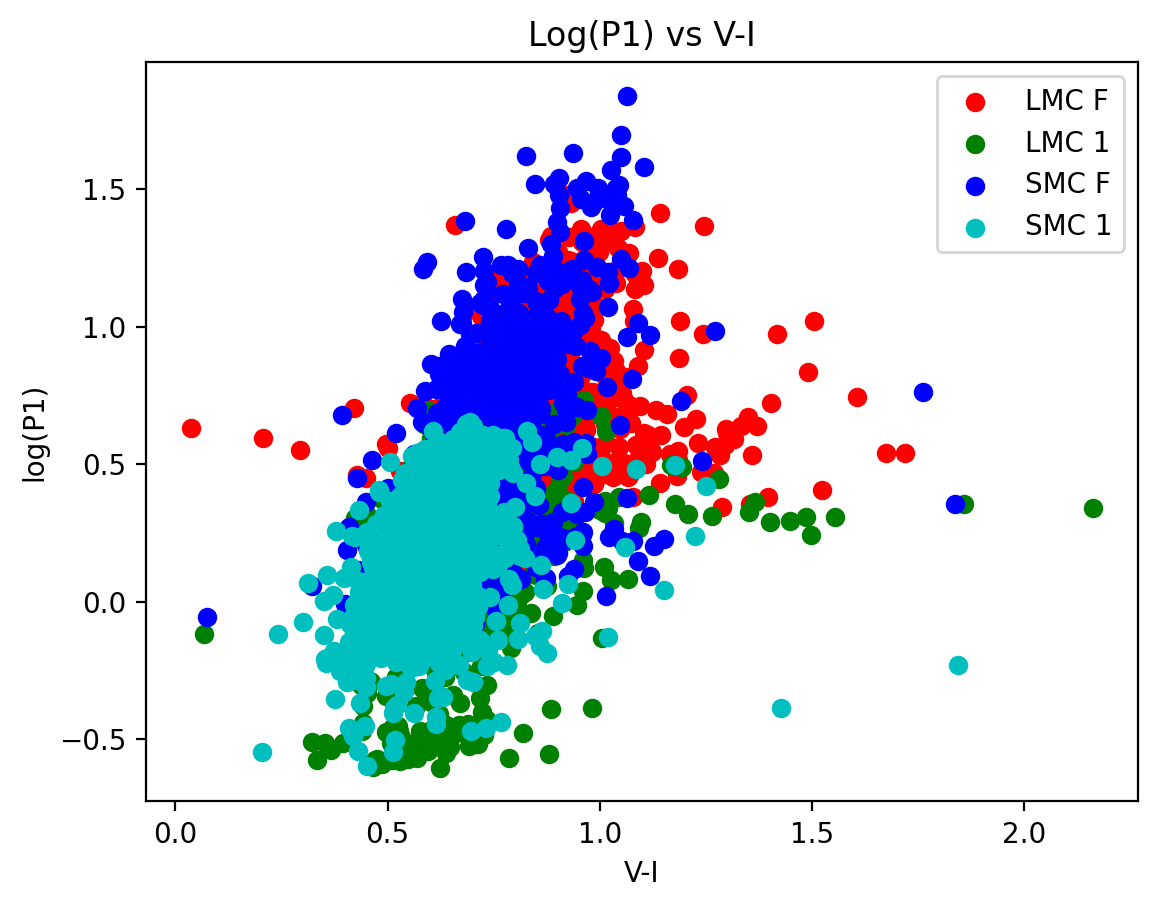

In [11]:
fig = plt.figure()
ax8 = fig.add_subplot()
for n in range(len(dfs)):
    ax8.scatter(dfs[n]['VI'], dfs[n]['logP1'], label=names[n], color=colors[n])
ax8.legend()
ax8.set_xlabel('V-I')
ax8.set_ylabel('log(P1)')
ax8.set_title('Log(P1) vs V-I')

In the Residuals v W plot, they seem to have a fairly linear relationship, which I suspect would be reduced in correlation if the residuals or the fit were weighted by the errors, which probably also scale with W.  In the logP1 vs V-I plot, the F modes seem more scattered than the 1 modes, and the LMC more than the SMC.